In [262]:
import pandas as pd
import numpy as np
from tqdm import trange, tqdm
import scipy as sc
import matplotlib.pyplot as plt
import math
from sklearn.linear_model import LinearRegression
from matplotlib import cm
from scipy.stats import gaussian_kde


# Behavioral Analysis

### Import data in pandas dataframe
Importing of data of finished and unfinished path

In [263]:
df_finished_paths = pd.read_csv('Dataset\wikispeedia_paths-and-graph.tar\wikispeedia_paths-and-graph\wikispeedia_paths-and-graph\paths_finished.tsv', 
                                  sep='\t', 
                                  skiprows=16,
                                  names = ["hashedIpAddress","timestamp","durationInSec","path","rating"],)
df_finished_paths.head()

,hashedIpAddress,timestamp,durationInSec,path,rating
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0


In [264]:
df_unfinished_paths = pd.read_csv('Dataset\wikispeedia_paths-and-graph.tar\wikispeedia_paths-and-graph\wikispeedia_paths-and-graph\paths_unfinished.tsv', 
                                  sep='\t', 
                                  skiprows=17,
                                  names = ["hashedIpAddress","timestamp","durationInSec","path","target","type"],)
df_unfinished_paths.head()

,hashedIpAddress,timestamp,durationInSec,path,target,type
0,2426091a53125110,1297054935,1804,Obi-Wan_Kenobi,Microsoft,timeout
1,26141fd878806294,1297055651,1805,Julius_Caesar,Caracas,timeout
2,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout
3,53a53bc244e08a6a,1297094761,49,Paraguay,Mount_St._Helens,restart
4,53a53bc244e08a6a,1297099105,1808,Paraguay;Bolivia,Mount_St._Helens,timeout


In [265]:
print(np.shape(df_finished_paths))
print(np.shape(df_unfinished_paths))

(51318, 5)
(24875, 6)


### Wrangling Data:
First, for the number of game played depending on the number of wins and losses, the number of wins and loss per players should be counted.
Players are differentiated using their Ip adress.

Dataframe "df_nbr_games" summarises the number of game winned, lost and played per player. 

In [266]:
df_finished_paths['nbr_win'] = df_finished_paths.groupby('hashedIpAddress')['hashedIpAddress'].transform('count')
df_finished_paths.head(5)

,hashedIpAddress,timestamp,durationInSec,path,rating,nbr_win
0,6a3701d319fc3754,1297740409,166,14th_century;15th_century;16th_century;Pacific...,NaN,4.0
1,3824310e536af032,1344753412,88,14th_century;Europe;Africa;Atlantic_slave_trad...,3.0,13.0
2,415612e93584d30e,1349298640,138,14th_century;Niger;Nigeria;British_Empire;Slav...,NaN,43.0
3,64dd5cd342e3780c,1265613925,37,14th_century;Renaissance;Ancient_Greece;Greece,NaN,3.0
4,015245d773376aab,1366730828,175,14th_century;Italy;Roman_Catholic_Church;HIV;R...,3.0,8.0


In [267]:
df_unfinished_paths['nbr_loss'] = df_unfinished_paths.groupby('hashedIpAddress')['hashedIpAddress'].transform('count')
>>> df_unfinished_paths.head()

,hashedIpAddress,timestamp,durationInSec,path,target,type,nbr_loss
0,2426091a53125110,1297054935,1804,Obi-Wan_Kenobi,Microsoft,timeout,1
1,26141fd878806294,1297055651,1805,Julius_Caesar,Caracas,timeout,1
2,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout,1
3,53a53bc244e08a6a,1297094761,49,Paraguay,Mount_St._Helens,restart,2
4,53a53bc244e08a6a,1297099105,1808,Paraguay;Bolivia,Mount_St._Helens,timeout,2


In [268]:
df_nbr_games = df_finished_paths[["hashedIpAddress",'nbr_win']].drop_duplicates().merge(df_unfinished_paths[['hashedIpAddress','nbr_loss']].drop_duplicates(),
                                                                                        how = "outer",
                                                                                        on="hashedIpAddress")
df_nbr_games = df_nbr_games.fillna(0)
df_nbr_games['nbr_play'] = df_nbr_games['nbr_win'] + df_nbr_games['nbr_loss']
df_nbr_games.head()

,hashedIpAddress,nbr_win,nbr_loss,nbr_play
0,6a3701d319fc3754,4.0,4.0,8.0
1,3824310e536af032,13.0,8.0,21.0
2,415612e93584d30e,43.0,37.0,80.0
3,64dd5cd342e3780c,3.0,0.0,3.0
4,015245d773376aab,8.0,0.0,8.0


In [269]:
#print(reg.intercept_, reg.coef_, reg.score(np.array(df_lim100['nbr_loss']).reshape(-1, 1),df_lim100['nbr_play']))

### Plotting
Plot of the analysis using a scatter plot and a linear regression.

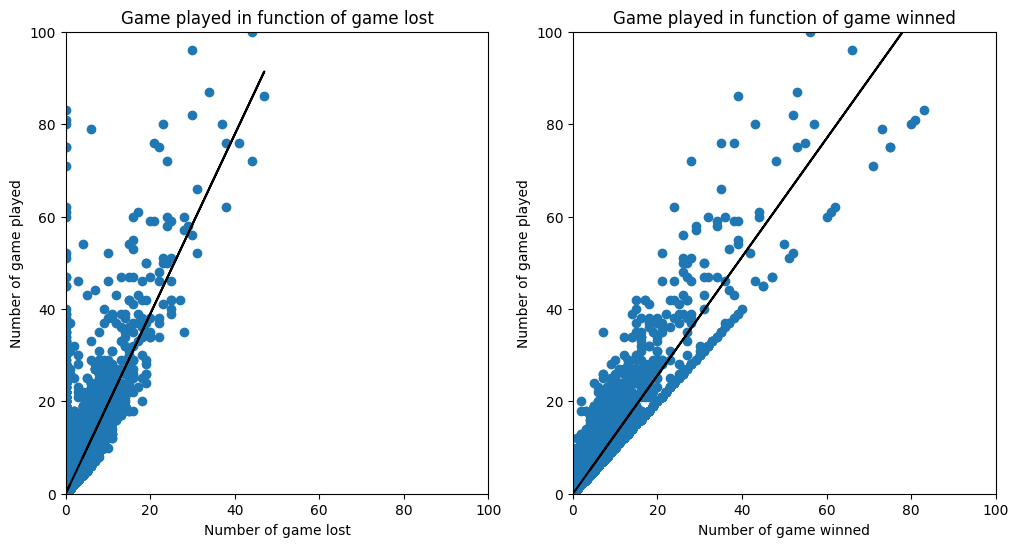

In [283]:
fig,axs = plt.subplots(1,2,figsize = (12,6))

df_lim100 = df_nbr_games[df_nbr_games["nbr_play"]<=100]

#Linear regression calculator
regression_loss = LinearRegression(fit_intercept=False).fit(np.array(df_lim100['nbr_loss']).reshape(-1, 1),df_lim100['nbr_play'])
axs[0].plot(df_lim100['nbr_loss'],regression_loss.predict(np.array(df_lim100['nbr_loss']).reshape(-1, 1)),'-k')

regression_win = LinearRegression(fit_intercept=False).fit(np.array(df_lim100['nbr_win']).reshape(-1, 1),df_lim100['nbr_play'])
axs[1].plot(df_lim100['nbr_win'],regression_win.predict(np.array(df_lim100['nbr_win']).reshape(-1, 1)),'-k')

#Density calculator:
"""xy_loss = np.vstack([df_nbr_games['nbr_loss'],df_nbr_games['nbr_play']])
density_loss = gaussian_kde(xy_loss)(xy_loss)
xy_win = np.vstack([df_nbr_games['nbr_win'],df_nbr_games['nbr_play']])
density_win = gaussian_kde(xy_win)(xy_win)"""

#Plotting
axs[0].scatter(df_nbr_games['nbr_loss'],df_nbr_games['nbr_play'])
axs[0].set_title("Game played in function of game lost")
axs[0].set_xlabel("Number of game lost")
axs[0].set_ylabel("Number of game played")
axs[0].set_ylim((0,100))
axs[0].set_xlim((0,100))


axs[1].scatter(df_nbr_games['nbr_win'],df_nbr_games['nbr_play'])
axs[1].set_title("Game played in function of game winned")
axs[1].set_xlabel("Number of game winned")
axs[1].set_ylabel("Number of game played")
axs[1].set_xlim((0,100))
axs[1].set_ylim((0,100))


plt.show()

In [271]:
coeff_loss = regression_loss.coef_[0]
R2_loss = regression_loss.score(np.array(df_lim100['nbr_loss']).reshape(-1, 1),df_lim100['nbr_play'])
coeff_win = regression_win.coef_[0]
R2_win = regression_win.score(np.array(df_lim100['nbr_win']).reshape(-1, 1),df_lim100['nbr_play'])
print('Slope Coefficient for loss: %.2f \n R^2 loss: %.5f' % (coeff_loss,R2_loss))
print('Slope Coefficient for win: %.2f \n R^2 win: %.5f'% (coeff_win,R2_win))
print('Mean number of game per player: %.2f'%(df_nbr_games['nbr_play'].mean()))

Slope Coefficient for loss: 1.94 
 R^2 loss: 0.46341
Slope Coefficient for win: 1.28 
 R^2 win: 0.83998
Mean number of game per player: 3.65


From the slope results above, when someone plays a game and lose it he usually plays another 0.94 games. We can round it to asssume that, after losing a game players often plays another one.

On the other hand, people play in average 1.28 games if winning. 

Therefore, from a comportemental point of view, a player tend to play more if losing than if winning. From a reward point of view, losing have a bigger impact on player's interest for the game, which fits researches. 

Following line shows that by only taking players that played 100 times or less, we discarded only 23 players, we consider them as outliers.

We also show how much games were played per person.

In [272]:
print("Players discarded when reducing to 100 game played: %.f" %(np.shape(df_nbr_games)[0]-np.shape(df_lim100)[0]))

Players discarded when reducing to 100 game played: 23


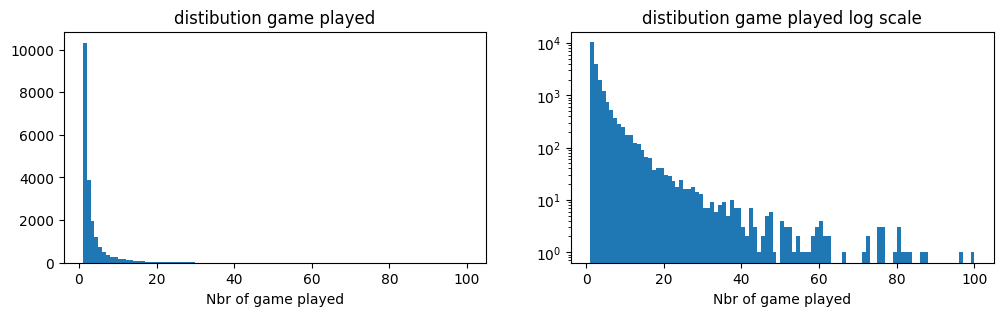

In [273]:
fig,axs = plt.subplots(1,2,figsize = (12,3))

axs[0].hist(df_lim100["nbr_play"],bins = np.arange(1,101,1))
axs[0].set_title("distibution game played")
axs[0].set_xlabel("Nbr of game played")

axs[1].hist(df_lim100["nbr_play"],bins = np.arange(1,101,1))
axs[1].set_title("distibution game played log scale")
axs[1].set_yscale("log")
axs[1].set_xlabel("Nbr of game played")
#axs[1].set_xscale("log")
plt.show()

### Time spent playing analysis
The following analysis follows the same idea as in the first one but using time spent. We use the fact that a game winned is the winning time and for lost game, losing time.

A player can lose by two ways: he either lose by restarting or by "giving up" when he don't do anything for half an hour. Because we want as losing time the time spent losing, we need to remove 30min for each timeout on the total time to be sure that the player is actively playing.

In [274]:
#datafame for winning_time:
df_finished_paths['time_spent_winning'] = df_finished_paths.groupby('hashedIpAddress')['durationInSec'].transform('sum')

#datafame for losing time:
df_unfinished_paths['time_spent'] = df_unfinished_paths.groupby('hashedIpAddress')['durationInSec'].transform('sum')
df_unfinished_paths['nbr_timeout'] = df_unfinished_paths[df_unfinished_paths['type']=='timeout'].groupby('hashedIpAddress')['type'].transform('count')
df_unfinished_paths['nbr_timeout'] = df_unfinished_paths.groupby('hashedIpAddress')['nbr_timeout'].transform('mean')
df_unfinished_paths = df_unfinished_paths.fillna(0)
df_unfinished_paths['time_spent_losing'] = df_unfinished_paths['time_spent'] - df_unfinished_paths['nbr_timeout'] * 1800 
#4 times the timeout happened before 30min, leading to a negative time sprent, put those numbers back to 0.
df_unfinished_paths[df_unfinished_paths['time_spent_losing']<0] = 0
df_unfinished_paths.head()

,hashedIpAddress,timestamp,durationInSec,path,target,type,nbr_loss,time_spent,nbr_timeout,time_spent_losing
0,2426091a53125110,1297054935,1804,Obi-Wan_Kenobi,Microsoft,timeout,1,1804,1.0,4.0
1,26141fd878806294,1297055651,1805,Julius_Caesar,Caracas,timeout,1,1805,1.0,5.0
2,2b015fb8181c48f2,1297090819,1818,Malawi;Democracy;Alexander_the_Great,First_Crusade,timeout,1,1818,1.0,18.0
3,53a53bc244e08a6a,1297094761,49,Paraguay,Mount_St._Helens,restart,2,1857,1.0,57.0
4,53a53bc244e08a6a,1297099105,1808,Paraguay;Bolivia,Mount_St._Helens,timeout,2,1857,1.0,57.0


In [275]:
# Add new time data in previous dataframe:
df_time_games = df_finished_paths[["hashedIpAddress",'time_spent_winning']].drop_duplicates().merge(
                                                                                        df_unfinished_paths[['hashedIpAddress','time_spent_losing']].drop_duplicates(),
                                                                                        how = "outer",
                                                                                        on="hashedIpAddress")
df_time_games = df_time_games.fillna(0)
df_time_games["time_played"] = df_time_games['time_spent_winning'] + df_time_games['time_spent_losing']

df_nbr_games = df_nbr_games.merge(df_time_games, how="outer", on="hashedIpAddress")
df_nbr_games = df_nbr_games.fillna(0)
df_nbr_games.head()

,hashedIpAddress,nbr_win,nbr_loss,nbr_play,time_spent_winning,time_spent_losing,time_played
0,6a3701d319fc3754,4.0,4.0,8.0,783.0,644.0,1427.0
1,3824310e536af032,13.0,8.0,21.0,1300.0,1287.0,2587.0
2,415612e93584d30e,43.0,37.0,80.0,3083.0,3601.0,6684.0
3,64dd5cd342e3780c,3.0,0.0,3.0,277.0,0.0,277.0
4,015245d773376aab,8.0,0.0,8.0,1535.0,0.0,1535.0


### Plotting
Plot of the analysis using a scatter plot and a linear regression.

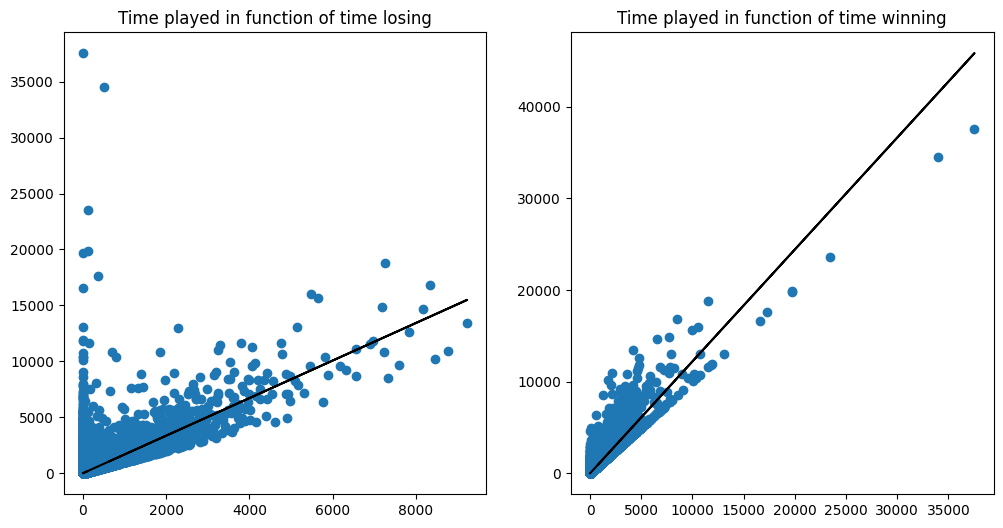

In [276]:
fig,axs = plt.subplots(1,2,figsize = (12,6))

df_lim100 = df_nbr_games[df_nbr_games["nbr_play"]<=100]

# Linear Regression computation
regression_loss_t = LinearRegression(fit_intercept=False).fit(np.array(df_lim100['time_spent_losing']).reshape(-1, 1),df_lim100['time_played'])
axs[0].plot(df_lim100['time_spent_losing'],regression_loss_t.predict(np.array(df_lim100['time_spent_losing']).reshape(-1, 1)),'-k')

regression_win_t = LinearRegression(fit_intercept=False).fit(np.array(df_lim100['time_spent_winning']).reshape(-1, 1),df_lim100['time_played'])
axs[1].plot(df_lim100['time_spent_winning'],regression_win_t.predict(np.array(df_lim100['time_spent_winning']).reshape(-1, 1)),'-k')

#Plot
axs[0].scatter(df_lim100['time_spent_losing'],df_lim100['time_played'])
axs[0].set_title("Time played in function of time losing")

axs[1].scatter(df_lim100['time_spent_winning'],df_lim100['time_played'])
axs[1].set_title("Time played in function of time winning")

plt.show()

In [277]:
coeff_loss_t = regression_loss_t.coef_[0]
R2_loss_t = regression_loss_t.score(np.array(df_lim100['time_spent_losing']).reshape(-1, 1),df_lim100['time_played'])
coeff_win_t = regression_win_t.coef_[0]
R2_win_t = regression_win_t.score(np.array(df_lim100['time_spent_winning']).reshape(-1, 1),df_lim100['time_played'])
print('Coefficient loss: %.2f \n R^2 loss: %.5f' % (coeff_loss_t,R2_loss_t))
print('Coefficient win: %.2f \n R^2 win: %.5f'% (coeff_win_t,R2_win_t))
print('mean time of game per player: %.2f s'%(df_nbr_games['time_played'].mean()))
print('mean time of one game: %.2f s'%(1/2*df_unfinished_paths['durationInSec'].mean()+1/2*df_finished_paths['durationInSec'].mean()))

Coefficient loss: 1.68 
 R^2 loss: 0.41239
Coefficient win: 1.22 
 R^2 win: 0.80860
mean time of game per player: 580.74 s
mean time of one game: 496.62 s


From the slope results above, when someone spend time losing, he usually spend more overal time playing the game than if he was winning. 

This might be due to the fact that losing results in more game played.
From a behaviroral perspective, when losing, someone requieres to use more parts from his brain to try to complete the task. Therefore from the reward point of view, a loser is more enroled in the game and a defeat is then even more impactful on him.

We then show how long does a game last per person.

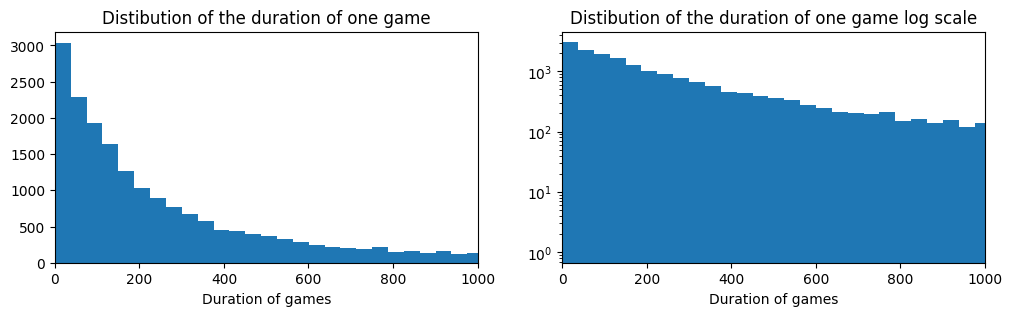

In [280]:
fig,axs = plt.subplots(1,2,figsize = (12,3))

axs[0].hist(df_lim100["time_played"],bins = 1000)
axs[0].set_title("Distibution of the duration of one game")
axs[0].set_xlabel("Duration of games")
axs[0].set_xlim([0,1000])

axs[1].hist(df_lim100["time_played"],bins = 1000)
axs[1].set_title("Distibution of the duration of one game log scale")
axs[1].set_xlabel("Duration of games")
axs[1].set_yscale("log")
axs[1].set_xlim([0,1000])

plt.show()